In [209]:
%matplotlib inline
import numpy as np
import matplotlib
import os
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from scipy.stats import stats
sns.set(style="whitegrid", color_codes=True)
plt.rcParams['figure.figsize'] = (12, 12)

In [210]:
orange_raster_dir = "/home/dat/Workspace/Thesis/orange_predictor/data/rasters_csv/2017-11-17"
csv_file = "/home/dat/Workspace/Thesis/data/Spreadsheet/Orange/orange.csv"

## Load data and calculate indices

In [211]:
df = pd.read_csv(csv_file)
df["raster_path"] = [os.path.join(orange_raster_dir, row["ID"]+".npy") for id, row in df.iterrows()]
# Remove improperly cropped images
df = df[df["ID"] != "26D"]
df = df[df["ID"] != "35E"]
df = df[df["ID"] != "42C"]
df = df[df["ID"] != "44F"]
df.describe()

,Chlorophyll,NDVI,WP
count,72.000000,72.000000,70.000000
mean,50.560828,0.821028,-8.615771
std,10.030131,0.040890,1.727900
min,25.453333,0.694674,-14.097143
25%,42.921333,0.794305,-9.437000
50%,51.537667,0.831986,-8.701571
75%,58.085333,0.852459,-7.409500
max,68.360000,0.871767,-5.288571


In [212]:
EPSILON = 1e-10

def NDVI(R, NIR):
    return (NIR - R) / (NIR + R + EPSILON)

def RedEdge(R, RE):
    return RE / (R + EPSILON)

def EVI(B, R, NIR):
    return 2.5 * (NIR - R) / (NIR + EPSILON) + 6 * R - 7.5 * B + 1 

def MCARI(G, R, RE):
    return (RE - R) - 0.23 * (RE - G) * RE / (R + EPSILON)

def GNDVI(G, NIR):
    return (NIR - G) / (NIR + G + EPSILON)

In [213]:
ndvi, rededge, evi, mcari, gndvi, channel_vals = [], [], [], [], [], []
for id, row in df.iterrows():
    raster = np.load(row["raster_path"])
    # Crop border to only get tree in image
    raster = raster[10:-10, 10:-10]
    b, g, r, re, nir = raster[:,:,0].mean(), raster[:,:,1].mean(), raster[:,:,2].mean(), raster[:,:,3].mean(), raster[:,:,4].mean()
    ndvi.append(NDVI(r, nir))
    rededge.append(RedEdge(r, re))
    evi.append(EVI(b, r, nir))
    mcari.append(MCARI(g, r, re))
    gndvi.append(GNDVI(g, nir))
    channel_vals.append([b, g, r, re, nir])
    
df["UAV_NDVI"] = ndvi
df["RedEdge"] = rededge
df["EVI"] = evi
df["MCARI"] = mcari
df["GNDVI"] = gndvi
df["channel_vals"] = channel_vals

In [214]:
df.head()

,ID,Chlorophyll,NDVI,WP,raster_path,UAV_NDVI,RedEdge,EVI,MCARI,GNDVI,channel_vals
0,14E,45.130,0.790624,-8.498,/home/dat/Workspace/Thesis/orange_predictor/da...,0.371546,2.528736,1.978037,0.188396,0.140478,"[0.19873777695, 0.305405423038, 0.185681928598..."
1,57B,53.224,0.822390,-7.544,/home/dat/Workspace/Thesis/orange_predictor/da...,0.324222,2.621469,1.758810,0.159224,0.139444,"[0.19854930797, 0.252509350343, 0.170621782335..."
2,22E,63.525,0.866294,-8.279,/home/dat/Workspace/Thesis/orange_predictor/da...,0.411300,2.673086,1.961145,0.181234,0.131009,"[0.190900555078, 0.287259650182, 0.15595518234..."
3,51F,61.880,0.871767,-9.449,/home/dat/Workspace/Thesis/orange_predictor/da...,0.378977,3.045495,2.051799,0.134791,0.186103,"[0.153063232588, 0.209672120006, 0.13760832975..."
4,10H,54.390,0.840800,-9.100,/home/dat/Workspace/Thesis/orange_predictor/da...,0.407119,2.825861,2.132202,0.152705,0.200304,"[0.162056680181, 0.237445533186, 0.15016463257..."


In [215]:
print("NDVI & NDVI:", stats.pearsonr(df.dropna()["UAV_NDVI"], df.dropna()["NDVI"])[0])

NDVI & NDVI: 0.593323326472


## Analyze distribution of ground truth

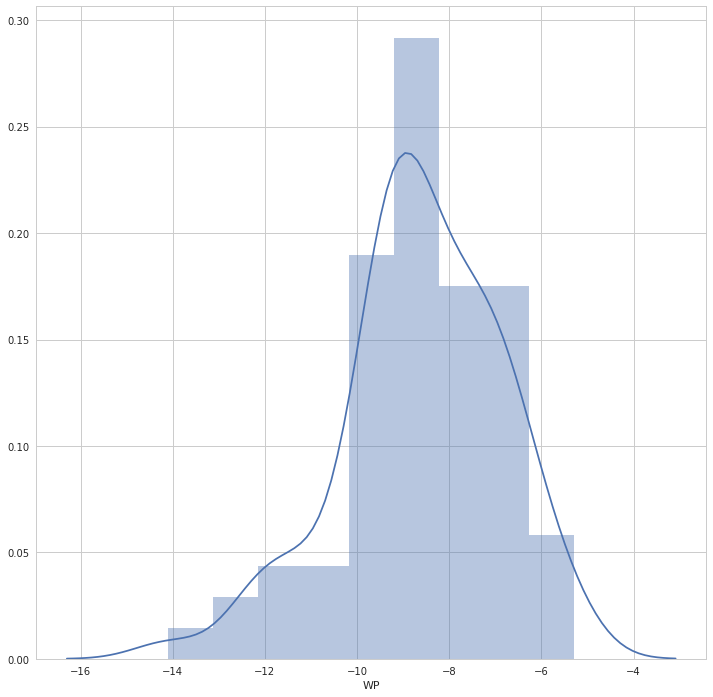

In [216]:
sns.distplot(df["WP"].dropna())

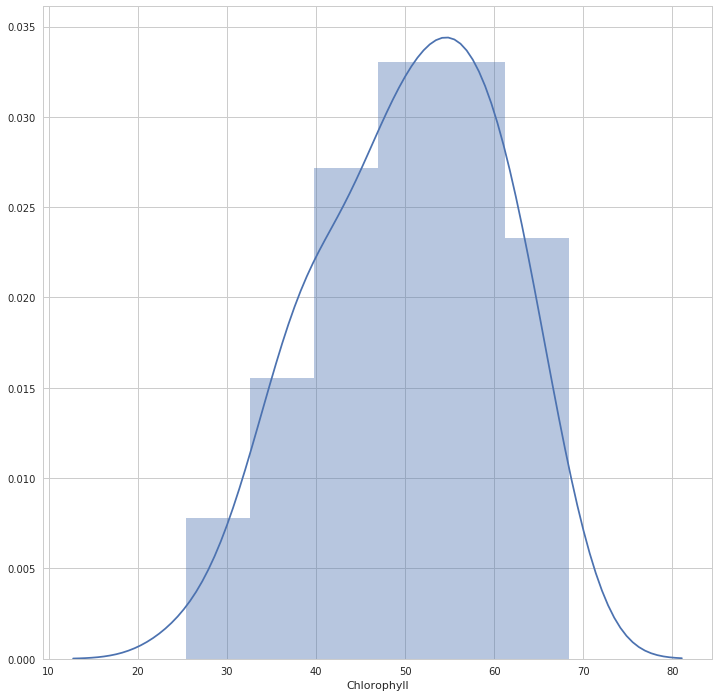

In [217]:
sns.distplot(df["Chlorophyll"].dropna())

## WP correlation with UAV indices

In [218]:
print("NDVI & WP:", stats.pearsonr(df.dropna()["UAV_NDVI"], df.dropna()["WP"])[0])
print("RedEdge & WP:", stats.pearsonr(df.dropna()["RedEdge"], df.dropna()["WP"])[0])
print("EVI & WP:", stats.pearsonr(df.dropna()["EVI"], df.dropna()["WP"])[0])
print("MCARI & WP:", stats.pearsonr(df.dropna()["MCARI"], df.dropna()["WP"])[0])
print("GNDVI & WP:", stats.pearsonr(df.dropna()["GNDVI"], df.dropna()["WP"])[0])

NDVI & WP: 0.542309174314
RedEdge & WP: 0.481264386297
EVI & WP: 0.481737705841
MCARI & WP: 0.523696499034
GNDVI & WP: 0.443908694598


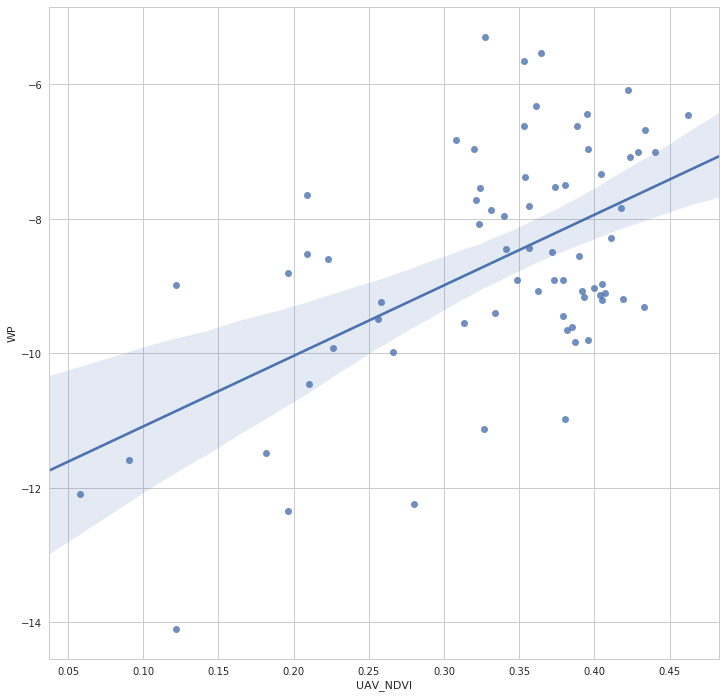

In [219]:
sns.regplot(x=df["UAV_NDVI"], y=df["WP"])

## Chlorophyll correlation with UAV indices

In [220]:
print("NDVI & Chlorophyll:", stats.pearsonr(df.dropna()["UAV_NDVI"], df.dropna()["Chlorophyll"])[0])
print("RedEdge & Chlorophyll:", stats.pearsonr(df.dropna()["RedEdge"], df.dropna()["Chlorophyll"])[0])
print("EVI & Chlorophyll:", stats.pearsonr(df.dropna()["EVI"], df.dropna()["Chlorophyll"])[0])
print("MCARI & Chlorophyll:", stats.pearsonr(df.dropna()["MCARI"], df.dropna()["Chlorophyll"])[0])
print("GNDVI & Chlorophyll:", stats.pearsonr(df.dropna()["GNDVI"], df.dropna()["Chlorophyll"])[0])

NDVI & Chlorophyll: 0.429874384727
RedEdge & Chlorophyll: 0.52321284355
EVI & Chlorophyll: 0.318791329952
MCARI & Chlorophyll: 0.299139712087
GNDVI & Chlorophyll: 0.269759374312


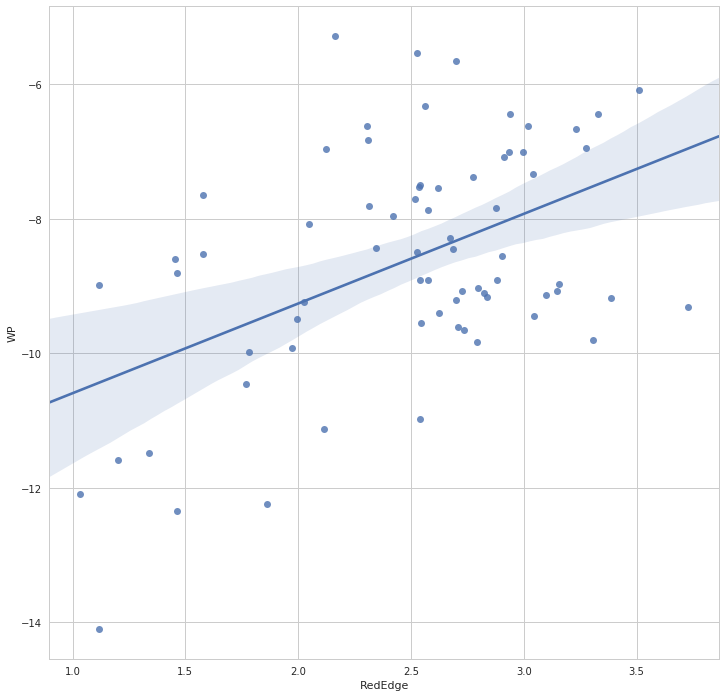

In [221]:
sns.regplot(x=df["RedEdge"], y=df["WP"])

## Learn index for WP

In [222]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import shuffle

In [242]:
def rmse(y, yhat):
    return np.sqrt(np.mean((y - yhat)**2))

def mae(y, yhat):
    return np.mean(np.abs(y - yhat))

def normalize(xs):
    max_x = max(xs)
    min_x = min(xs)
    return [(x-min_x)/(max_x-min_x) for x in xs]

In [243]:
X = np.array(list(df.dropna()["channel_vals"]))
y = np.array(normalize(list(df.dropna()["WP"])))

X, y = shuffle(X, y)

In [244]:
model = Pipeline([("poly", PolynomialFeatures(degree=1)), ("linear", LinearRegression(fit_intercept=False))])
predicted = cross_val_predict(model, X, y, cv=10)
print("RMSE:", rmse(predicted, y))
print("MAE:", mae(predicted, y))
print("R2:", r2_score(y, predicted))

RMSE: 0.172691236416
MAE: 0.142352447285
R2: 0.213745193126


Text(0,0.5,'Predicted WP')

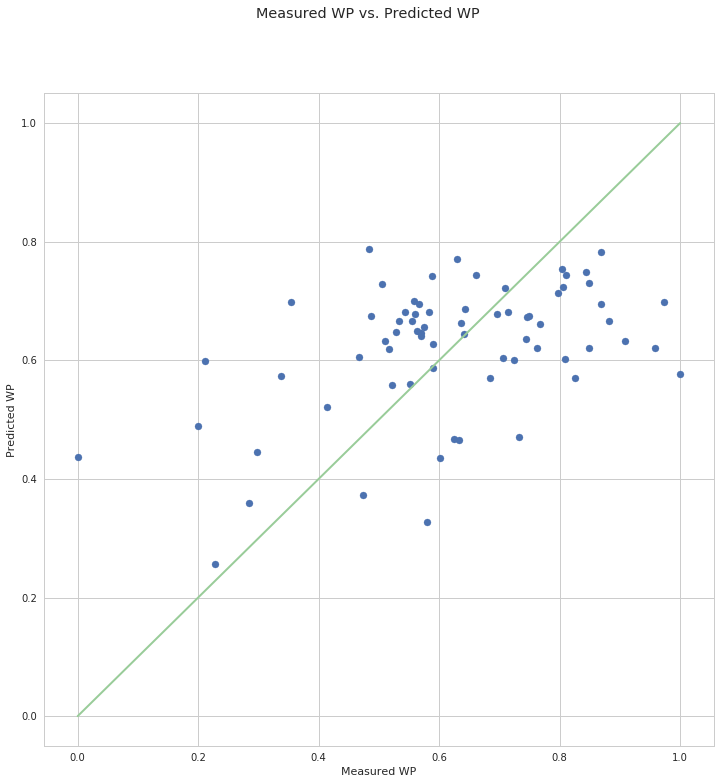

In [235]:
fig = plt.figure()
plt.scatter(y, predicted)
plt.plot(range(2), range(2), color="#99CC99", linewidth=2)
fig.suptitle("Measured WP vs. Predicted WP")
plt.xlabel("Measured WP")
plt.ylabel("Predicted WP")

## Learn index for chlorophyll

In [262]:
X = np.array(list(df["channel_vals"]))
y = np.array(normalize(list(df["Chlorophyll"])))

X, y = shuffle(X, y)

In [263]:
model = Pipeline([("poly", PolynomialFeatures(degree=1)), ("linear", LinearRegression(fit_intercept=False))])
predicted = cross_val_predict(model, X, y, cv=10)
print("RMSE:", rmse(predicted, y))
print("MAE:", mae(predicted, y))
print("R2:", r2_score(y, predicted))

RMSE: 0.165285393691
MAE: 0.129794668353
R2: 0.493033248094


Text(0,0.5,'Predicted Chlorophyll')

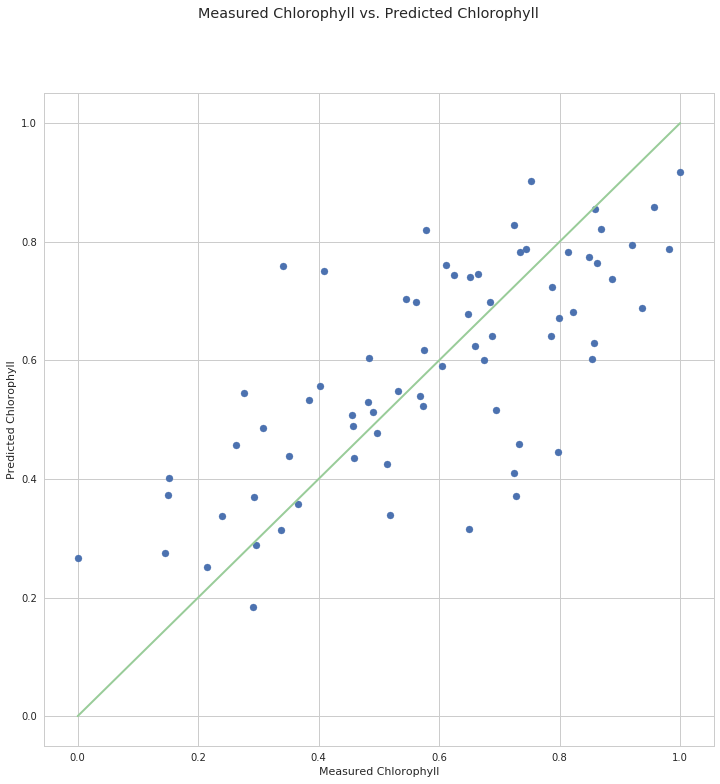

In [240]:
fig = plt.figure()
plt.scatter(y, predicted)
plt.plot(range(2), range(2), color="#99CC99", linewidth=2)
fig.suptitle("Measured Chlorophyll vs. Predicted Chlorophyll")
plt.xlabel("Measured Chlorophyll")
plt.ylabel("Predicted Chlorophyll")